<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_Deep_Learning_Con_TernsorFlow_Machine-Learning_e_IA-/blob/master/scripts/tema08/03-skip-grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#pip install tensorflow==1.14

# Bag of Words Contínuo o Skip Gramas

- King - man + woman = Queen
- Indian Pale Ale - hops + malt = Stout

- Si queremos predecir una palabra objetivo a partir de un contexto (palabras que la rodean): Continuous Bag of Words
- Si queremos predecir las palabras que rodean (contexto) a una palabra objetivo: Skip-Grama

## Descarga de datos

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import string
import requests
import collections
import io
import tarfile
import urllib.request
import nltk
from nltk.corpus import stopwords
session = tf.Session()

In [6]:
batch_size = 50
embedding_size = 200
vocabulary_size = 10000
generations = 50000
print_loss_every = 500
num_sampled = int(batch_size/2)
window_size = 2
nltk.download('stopwords')
stops = stopwords.words('english')
print_valid_every = 2000
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stops

In [0]:
def load_movies_data():
    save_folder_name = "../../datasets/movies_data"
    pos_file = os.path.join(save_folder_name, 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polarity.neg')
    
    if os.path.exists(save_folder_name):
        ## Podemos cargar la info directamente desde el PC
        pos_data = []
        with open(pos_file, 'r') as temp_pos_file:
            for row in temp_pos_file:
                pos_data.append(row)
                
        neg_data = []
        with open(neg_file, 'r') as temp_neg_file:
            for row in temp_neg_file:
                neg_data.append(row)
        
    else:
        ## Debemos descargar los ficheros de internet y guardarlos en esta carpeta
        url = "http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz"
        stream_data = urllib.request.urlopen(url)
        tmp = io.BytesIO()
        while True:
            s = stream_data.read(16384)
            if not s: 
                break
            tmp.write(s)
        stream_data.close()
        tmp.seek(0)
        
        tar_file = tarfile.open(fileobj=tmp, mode='r:gz')
        pos = tar_file.extractfile('rt-polaritydata/rt-polarity.pos')
        neg = tar_file.extractfile('rt-polaritydata/rt-polarity.neg')
        
        pos_data = []
        for line in pos:
            pos_data.append(line.decode('ISO-8859-1').encode('ascii', errors='ignore').decode())
            
        neg_data = []
        for line in neg:
            neg_data.append(line.decode('ISO-8859-1').encode('ascii', errors='ignore').decode())
            
        tar_file.close()
        
        if not os.path.exists(save_folder_name):
            os.makedirs(save_folder_name)
        with open(pos_file, 'w') as pos_file_handler:
            pos_file_handler.write(''.join(pos_data))
        with open(neg_file, 'w') as neg_file_handler:
            neg_file_handler.write(''.join(neg_data))
    
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    return (texts, target)         

In [0]:
texts, target = load_movies_data()

In [30]:
tes =texts[0:8]
print(tes)
tes = [x.lower() for x in tes]# paso a minusculas
tes = [''.join(c for c in x if c not in string.punctuation) for x in tes]# elimino los putos y signos de esclamacion
print(tes)
tes = [''.join(c for c in x if c not in '0123456789') for x in tes]# elimina los numeros
print(tes)
tes = [' '.join(word for word in x.split() if word not in (stops)) for x in tes]# elimino las stop
print(tes)
tes = [' '.join(x.split()) for x in tes]
print(tes)
tar = [target[ix] for ix, x in enumerate(tes) if len(x.split())>2]
print(tar)

['rock destined st centurys new conan hes going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal', 'gorgeously elaborate continuation lord rings trilogy huge column words cannot adequately describe cowriterdirector peter jacksons expanded vision j r r tolkiens middleearth', 'effective tootepid biopic', 'sometimes like go movies fun wasabi good place start', 'emerges something rare issue movie thats honest keenly observed doesnt feel like one', 'film provides great insight neurotic mindset comics even reached absolute top game', 'offers rare combination entertainment education', 'perhaps picture ever made literally showed road hell paved good intentions']
['rock destined st centurys new conan hes going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal', 'gorgeously elaborate continuation lord rings trilogy huge column words cannot adequately describe cowriterdirector peter jacksons expanded vision j r r tolkiens middleearth', 

In [17]:
target[0:3]

[1, 1, 1]

## Limpieza de datos

In [0]:
def normalize_text(texts, stops):
    texts = [x.lower() for x in texts]# paso a minusculas
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]# elimino los putos y signos de esclamacion
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]# elimina los numeros
    texts = [' '.join(word for word in x.split() if word not in (stops)) for x in texts]# elimino las stop
    texts = [' '.join(x.split()) for x in texts]
    return texts

In [0]:
texts = normalize_text(texts, stops)

In [29]:
texts[0]

'rock destined st centurys new conan hes going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal'

In [38]:
len(texts)

10406

In [0]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>2]
texts = [x for x in texts if len(x.split())>2]

In [40]:
len(texts)

10406

In [0]:
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    count = [['RARE', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))# nos da las palabras mas frecuentes del dicionario
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    return word_dict

In [0]:
word_dict = build_dictionary(texts, vocabulary_size)

In [65]:
word_dict

{'RARE': 0,
 'film': 1,
 'movie': 2,
 'one': 3,
 'like': 4,
 'story': 5,
 'much': 6,
 'even': 7,
 'good': 8,
 'comedy': 9,
 'time': 10,
 'characters': 11,
 'films': 12,
 'little': 13,
 'way': 14,
 'funny': 15,
 'make': 16,
 'movies': 17,
 'enough': 18,
 'never': 19,
 'makes': 20,
 'may': 21,
 'us': 22,
 'best': 23,
 'work': 24,
 'director': 25,
 'doesnt': 26,
 'bad': 27,
 'love': 28,
 'life': 29,
 'would': 30,
 'theres': 31,
 'well': 32,
 'new': 33,
 'could': 34,
 'something': 35,
 'really': 36,
 'made': 37,
 'performances': 38,
 'thats': 39,
 'many': 40,
 'drama': 41,
 'look': 42,
 'plot': 43,
 'still': 44,
 'see': 45,
 'isnt': 46,
 'every': 47,
 'two': 48,
 'nothing': 49,
 'people': 50,
 'better': 51,
 'long': 52,
 'without': 53,
 'get': 54,
 'action': 55,
 'fun': 56,
 'great': 57,
 'though': 58,
 'might': 59,
 'big': 60,
 'also': 61,
 'cast': 62,
 'another': 63,
 'ever': 64,
 'kind': 65,
 'first': 66,
 'audience': 67,
 'humor': 68,
 'sense': 69,
 'character': 70,
 'performance': 71,

In [0]:
def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence:
            if word in word_dict:
                word_ix = word_dict[word]#posición/ID de la palabra en el word dict
            else:
                word_ix = 0 ##posición/ID de la palabra RARE
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data

In [64]:
# creamos dicionario de palabras 
word_dict_rev = dict(zip(word_dict.values(), word_dict.keys()))
word_dict_rev

{0: 'RARE',
 1: 'film',
 2: 'movie',
 3: 'one',
 4: 'like',
 5: 'story',
 6: 'much',
 7: 'even',
 8: 'good',
 9: 'comedy',
 10: 'time',
 11: 'characters',
 12: 'films',
 13: 'little',
 14: 'way',
 15: 'funny',
 16: 'make',
 17: 'movies',
 18: 'enough',
 19: 'never',
 20: 'makes',
 21: 'may',
 22: 'us',
 23: 'best',
 24: 'work',
 25: 'director',
 26: 'doesnt',
 27: 'bad',
 28: 'love',
 29: 'life',
 30: 'would',
 31: 'theres',
 32: 'well',
 33: 'new',
 34: 'could',
 35: 'something',
 36: 'really',
 37: 'made',
 38: 'performances',
 39: 'thats',
 40: 'many',
 41: 'drama',
 42: 'look',
 43: 'plot',
 44: 'still',
 45: 'see',
 46: 'isnt',
 47: 'every',
 48: 'two',
 49: 'nothing',
 50: 'people',
 51: 'better',
 52: 'long',
 53: 'without',
 54: 'get',
 55: 'action',
 56: 'fun',
 57: 'great',
 58: 'though',
 59: 'might',
 60: 'big',
 61: 'also',
 62: 'cast',
 63: 'another',
 64: 'ever',
 65: 'kind',
 66: 'first',
 67: 'audience',
 68: 'humor',
 69: 'sense',
 70: 'character',
 71: 'performance',

In [0]:
text_data = text_to_numbers(texts, word_dict)

In [0]:
text_data[0]

In [0]:
# valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']
valid_examples = [word_dict[x] for x in valid_words]

In [76]:
valid_examples

[1490, 28, 940, 205, 359]

In [0]:
def generate_batch_data(sentences, batch_size, window_size, method = 'skip_gram'):
    '''
        Mi perro come su comida -> (Mi, come), (perro, come), (su, come), (comida, come)
    '''
    batch_data = []
    label_data = []
    
    while len(batch_data) < batch_size:
        rand_sentences = np.random.choice(sentences)
        window_seq = [rand_sentences[max((ix-window_size),0):(ix+window_size+1)] 
                      for ix, x in enumerate(rand_sentences)]
        label_idx = [ix if ix < window_size else window_size for ix, x in enumerate(window_seq)]
        
        if method == 'skip_gram':
            batch_and_labels = [(x[y], x[:y]+x[(y+1):]) for x,y in zip(window_seq, label_idx)]
            tuple_data = [(x,y_) for x, y in batch_and_labels for y_ in y]
        else:
            raise ValueError("Método {} no implementado".format(method))
        
        batch, labels = [list(x) for x in zip(*tuple_data)]
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
        
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return (batch_data, label_data)

## Entrenar con los Skip Grams

In [0]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1, 1))
x_inputs = tf.placeholder(tf.int32, shape =[batch_size])
y_target = tf.placeholder(tf.int32, shape = [batch_size,1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [0]:
embed = tf.nn.embedding_lookup(embeddings, x_inputs)

In [0]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                              stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [0]:
# funcion de error que contrasta el ruido
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                    inputs=embed, labels=y_target, 
                                     num_sampled = num_sampled, num_classes=vocabulary_size))

In [0]:
# la distancia coseno
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [0]:
# funcion de optimizacion con radio de aprendizaje alto
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

In [0]:
# inicializamos variables
init = tf.global_variables_initializer()
session.run(init)

In [78]:
loss_vect = []
loss_x_vect = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size, window_size)
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    session.run(optimizer, feed_dict=feed_dict)
    
    if (i+1) % print_loss_every == 0:
        loss_val = session.run(loss, feed_dict=feed_dict)
        loss_vect.append(loss_val)
        loss_x_vect.append(i+1)
        print("Iteración {}, Pérdida: ".format(i+1, loss_val))
    
    ## Validación de palabras más cercanas a las 5 seleccionadas
    if (i+1) % print_valid_every == 0:
        sim = session.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dict_rev[valid_examples[j]]
            top_k = 10
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_string = "Palabras cercanas a {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dict_rev[nearest[k]]
                log_string = "%s %s, "%(log_string, close_word)
            print(log_string)

Iteración 500, Pérdida: 
Iteración 1000, Pérdida: 
Iteración 1500, Pérdida: 
Iteración 2000, Pérdida: 
Palabras cercanas a cliche: foremost,  formulaic,  kissinger,  points,  scarcely,  decided,  sticks,  bar,  redeems,  ser, 
Palabras cercanas a love: absorbing,  flick,  blockbusters,  deep,  greek,  done,  carved,  nakata,  whimsical,  takes, 
Palabras cercanas a hate: stamina,  key,  innocuous,  earnharts,  suck,  knockout,  tuxedo,  murk,  oldschool,  tout, 
Palabras cercanas a silly: unholy,  worldclass,  juvenile,  wallop,  laundry,  comment,  spider,  mattei,  farts,  ellen, 
Palabras cercanas a sad: strikes,  dont,  unbelievable,  dish,  aptly,  unexpected,  driving,  threatening,  code,  golf, 
Iteración 2500, Pérdida: 
Iteración 3000, Pérdida: 
Iteración 3500, Pérdida: 
Iteración 4000, Pérdida: 
Palabras cercanas a cliche: foremost,  formulaic,  kissinger,  points,  scarcely,  decided,  sticks,  bar,  redeems,  ser, 
Palabras cercanas a love: absorbing,  flick,  blockbusters,

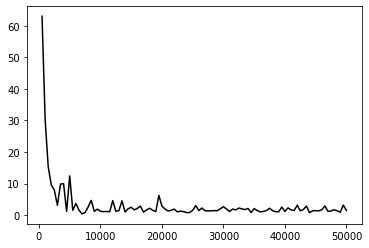

In [79]:
plt.plot(loss_x_vect, loss_vect, 'k-', label = "Función de pérdidas")

In [80]:
texts[0]

'rock destined st centurys new conan hes going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal'

In [82]:
word_dict["rock"], word_dict["destined"], word_dict["st"], word_dict["new"], word_dict["conan"]

(527, 2395, 2145, 33, 6931)

- Si tomamos la palabra "destined" como objetivo, es la número 2457
- Con una ventana de dimensión 1 -> 535 y 2251

In [0]:
M = session.run(embeddings)

In [86]:
M[2457]

array([-0.94085217,  0.3018415 , -0.20496845,  0.8809376 , -0.03157401,
        0.09671855, -0.34895825,  0.0525012 , -0.056144  , -0.8287835 ,
        0.38963437,  0.8470657 ,  0.21283913, -0.00479364,  0.08667302,
        0.02141881, -0.9086523 , -0.8994634 , -0.08298612, -0.39123535,
        0.7060497 , -0.34829712,  0.43653226, -0.73139   ,  0.9478893 ,
        0.5507016 , -0.36344337,  0.17577004,  0.69085383,  0.09066463,
       -0.19932747, -0.92004967,  0.62579393, -0.751065  , -0.6616819 ,
        0.5659108 , -0.61595845, -0.1494143 ,  0.44062614, -0.7353487 ,
       -0.93868613, -0.3512423 ,  0.5603788 , -0.88976383, -0.92388606,
       -0.8207116 , -0.73769355, -0.8929372 ,  0.63512874, -0.21792316,
        0.3417163 , -0.54464126, -0.51051545,  0.3117528 ,  0.61365557,
       -0.9293215 ,  0.59742165, -0.87630224,  0.6996298 , -0.88530874,
        0.44440293,  0.3279984 ,  0.354733  , -0.78348804, -0.35132837,
       -0.85925174, -0.21444535, -0.40745234,  0.44598794,  0.54

In [87]:
M[535]

array([ 0.51949406, -0.7978132 ,  0.11353517, -0.20571327,  0.6886437 ,
       -0.8747108 ,  0.4549539 , -0.21861792, -0.9981556 ,  0.73735404,
        0.24903846,  0.58532214, -0.01630449,  0.43882203, -0.8782716 ,
       -0.24567676, -0.50537133, -0.56144476,  0.86199546,  0.2472887 ,
        0.05562735, -0.8524542 ,  0.93504214, -0.7502713 , -0.64731   ,
        0.3115635 ,  0.96684027,  0.9348841 ,  0.48431826, -0.92469215,
        0.8291633 , -0.49910045,  0.9344413 , -0.4682858 ,  0.88021326,
        0.41048336,  0.54540825, -0.7191105 ,  0.24164987,  0.19714928,
        0.77009726,  0.24259281, -0.4405005 ,  0.86296535, -0.42323732,
       -0.5004895 , -0.9574113 ,  0.93067956,  0.76816106, -0.412009  ,
        0.75582576, -0.5167022 , -0.4453411 , -0.6910999 , -0.5198505 ,
        0.8617332 , -0.96271443, -0.30802345,  0.39388895,  0.8255265 ,
       -0.38078976,  0.4923129 ,  0.6718621 , -0.03663921, -0.18266273,
       -0.31495547,  0.65248036, -0.53200006, -0.5674851 , -0.36